Import data

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import math
import warnings

In [47]:
warnings.filterwarnings('ignore')  # Suppress all warnings
INPUT_FILE = 'step_records_raw.csv'
df = pd.read_csv(INPUT_FILE)
display(df.head())
df.info()

,type,value,unit,startDate,endDate,sourceName
0,HKQuantityTypeIdentifierStepCount,45.0,count,2019-06-04 18:15:42 +0100,2019-06-04 18:20:46 +0100,“Administrator”的 iPhone
1,HKQuantityTypeIdentifierStepCount,55.0,count,2019-06-04 19:05:30 +0100,2019-06-04 19:11:30 +0100,“Administrator”的 iPhone
2,HKQuantityTypeIdentifierStepCount,509.0,count,2019-06-04 19:11:30 +0100,2019-06-04 19:16:42 +0100,“Administrator”的 iPhone
3,HKQuantityTypeIdentifierStepCount,497.0,count,2019-06-04 19:16:42 +0100,2019-06-04 19:21:54 +0100,“Administrator”的 iPhone
4,HKQuantityTypeIdentifierStepCount,258.0,count,2019-06-04 19:21:54 +0100,2019-06-04 19:27:26 +0100,“Administrator”的 iPhone


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41209 entries, 0 to 41208
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   type        41209 non-null  object 
 1   value       41209 non-null  float64
 2   unit        41209 non-null  object 
 3   startDate   41209 non-null  object 
 4   endDate     41209 non-null  object 
 5   sourceName  41209 non-null  object 
dtypes: float64(1), object(5)
memory usage: 1.9+ MB


In this step, we process data, drop irrelevant column, convert data feature to their intrinsic type

In [48]:
# Drop columns type, unit and sourcename
df_col_dropped = df.drop(columns=['type', 'sourceName', 'unit'])
df_col_dropped = df_col_dropped.rename(columns={'value': 'steps'})
display(df_col_dropped.head())

,steps,startDate,endDate
0,45.0,2019-06-04 18:15:42 +0100,2019-06-04 18:20:46 +0100
1,55.0,2019-06-04 19:05:30 +0100,2019-06-04 19:11:30 +0100
2,509.0,2019-06-04 19:11:30 +0100,2019-06-04 19:16:42 +0100
3,497.0,2019-06-04 19:16:42 +0100,2019-06-04 19:21:54 +0100
4,258.0,2019-06-04 19:21:54 +0100,2019-06-04 19:27:26 +0100


In [49]:
# convert data type
df_col_dropped['startDate'] = pd.to_datetime(df_col_dropped['startDate'], utc=True).dt.tz_convert(None)
df_col_dropped['endDate'] = pd.to_datetime(df_col_dropped['endDate'], utc=True).dt.tz_convert(None)
display(df_col_dropped.head())

,steps,startDate,endDate
0,45.0,2019-06-04 17:15:42,2019-06-04 17:20:46
1,55.0,2019-06-04 18:05:30,2019-06-04 18:11:30
2,509.0,2019-06-04 18:11:30,2019-06-04 18:16:42
3,497.0,2019-06-04 18:16:42,2019-06-04 18:21:54
4,258.0,2019-06-04 18:21:54,2019-06-04 18:27:26


In [50]:
# Add year and month as new features
df_col_dropped['year'] = df_col_dropped['startDate'].dt.year
df_col_dropped['month'] = df_col_dropped['startDate'].dt.month
df_col_dropped['date'] = df_col_dropped['startDate'].dt.date
# display(df_col_dropped.head())

dict = {'steps': np.sum}
daily_steps = (
    df_col_dropped
    .groupby('date')
    .agg({
        'steps': 'sum',
        'startDate': 'min',
        'endDate': 'max'
    })
    .reset_index()
)

# display(daily_steps.head())

daily_steps['year'] = daily_steps['startDate'].dt.year
daily_steps['month'] = daily_steps['startDate'].dt.month
# Set date as index
daily_steps.set_index('date', inplace=True)
display(daily_steps.head())

,steps,startDate,endDate,year,month
date,,,,,
2019-06-04,3000.0,2019-06-04 17:15:42,2019-06-04 19:29:14,2019,6
2019-06-05,5658.0,2019-06-05 05:21:54,2019-06-05 16:20:51,2019,6
2019-06-06,6236.0,2019-06-06 05:57:42,2019-06-06 21:41:32,2019,6
2019-06-07,9432.0,2019-06-07 05:27:14,2019-06-07 23:47:13,2019,6
2019-06-08,16438.0,2019-06-08 08:43:55,2019-06-08 21:46:33,2019,6


In [51]:
# Extract data from 2024-2025
df_filtered = daily_steps[(daily_steps['year'] >= 2024) & (daily_steps['year'] <= 2025)]
display(df_filtered.head(10))
df_filtered.info()

,steps,startDate,endDate,year,month
date,,,,,
2024-01-01,7464.0,2024-01-01 02:24:55,2024-01-01 13:38:58,2024,1
2024-01-02,7969.0,2024-01-02 08:45:20,2024-01-02 21:05:45,2024,1
2024-01-03,8866.0,2024-01-03 09:07:52,2024-01-03 18:42:13,2024,1
2024-01-04,2108.0,2024-01-04 10:53:12,2024-01-04 21:51:27,2024,1
2024-01-05,9112.0,2024-01-05 08:44:26,2024-01-05 22:08:26,2024,1
2024-01-06,6016.0,2024-01-06 09:10:37,2024-01-06 15:25:49,2024,1
2024-01-07,38.0,2024-01-07 13:30:00,2024-01-07 17:13:13,2024,1
2024-01-08,9083.0,2024-01-08 08:59:21,2024-01-08 23:26:51,2024,1
2024-01-09,4805.0,2024-01-09 06:57:01,2024-01-09 15:09:42,2024,1


<class 'pandas.core.frame.DataFrame'>
Index: 710 entries, 2024-01-01 to 2025-12-16
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   steps      710 non-null    float64       
 1   startDate  710 non-null    datetime64[ns]
 2   endDate    710 non-null    datetime64[ns]
 3   year       710 non-null    int32         
 4   month      710 non-null    int32         
dtypes: datetime64[ns](2), float64(1), int32(2)
memory usage: 27.7+ KB


Data Visualization

In [52]:
# Configure font sizes
plt.rc('font', size=10) 
plt.rc('axes', labelsize=16)
plt.rc('legend', fontsize=16)

def plot_data(x, y, title = '', xlabel= 'Date', ylabel = ''):
    
    plt.figure(figsize=(16,5))
    plt.plot(x, y, '.-', color='black')
    plt.xlabel(xlabel=xlabel)
    plt.ylabel(ylabel=ylabel)
    plt.title(title)
    
    plt.legend()
    plt.show()

In [53]:
# Movinf average
def moving_average(df, window_size):

    averages = []
    
    for i in range(len(df)):
        
        # Extract a window from the dataframe
        # YOUR CODE HERE
        start = max(0, i - window_size + 1)
        end = i + 1
        window = df.iloc[start : end]
        # Compute the average
        average = window.mean(numeric_only=True)
        
        # Append the average to the list of averages
        averages.append(average)

    # Create the dataframe that will be returned
    smoothed = pd.DataFrame(averages, columns=df.columns)
    smoothed.set_index(df.index, inplace=True)
    
    return smoothed

,steps,startDate,endDate,year,month
date,,,,,
2024-01-01,7464.000000,NaN,NaN,2024.0,1.0
2024-01-02,7716.500000,NaN,NaN,2024.0,1.0
2024-01-03,8099.666667,NaN,NaN,2024.0,1.0
2024-01-04,6601.750000,NaN,NaN,2024.0,1.0
2024-01-05,7103.800000,NaN,NaN,2024.0,1.0


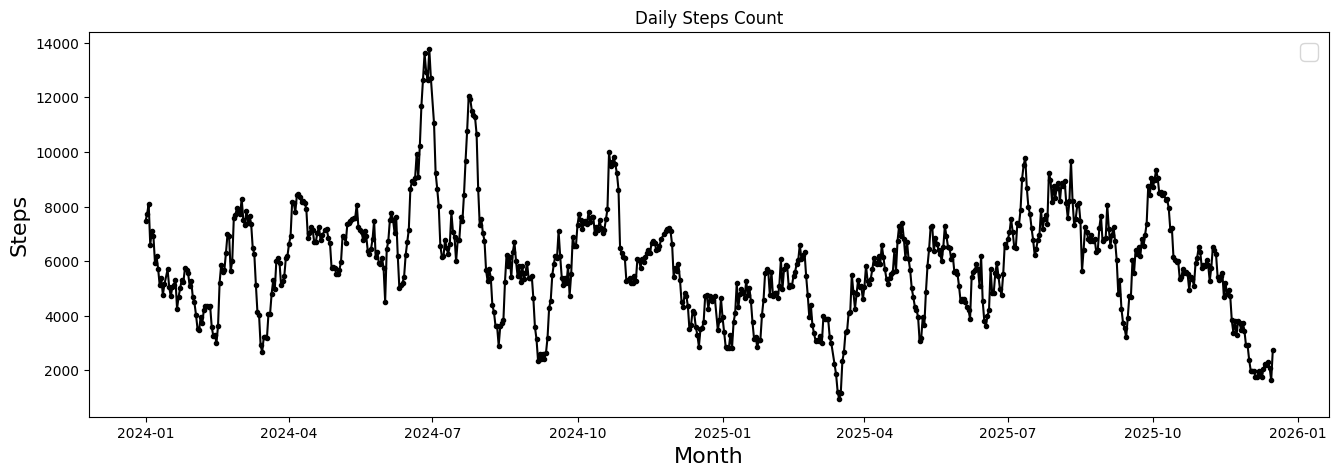

In [54]:

smoothed_df = moving_average(df_filtered, 7)
display(smoothed_df.head())
x = smoothed_df.index
y = smoothed_df['steps']
plot_data(x, y, 'Daily Steps Count', 'Month', 'Steps')


In [55]:
# weekly steps stats
df_filtered.index = pd.to_datetime(df_filtered.index)
df_filtered['weekday'] = df_filtered.index.weekday
df_filtered['is_weekend'] = df_filtered['weekday'] >= 5
df_filtered

,steps,startDate,endDate,year,month,weekday,is_weekend
date,,,,,,,
2024-01-01,7464.0,2024-01-01 02:24:55,2024-01-01 13:38:58,2024,1,0,False
2024-01-02,7969.0,2024-01-02 08:45:20,2024-01-02 21:05:45,2024,1,1,False
2024-01-03,8866.0,2024-01-03 09:07:52,2024-01-03 18:42:13,2024,1,2,False
2024-01-04,2108.0,2024-01-04 10:53:12,2024-01-04 21:51:27,2024,1,3,False
2024-01-05,9112.0,2024-01-05 08:44:26,2024-01-05 22:08:26,2024,1,4,False
...,...,...,...,...,...,...,...
2025-12-12,2256.0,2025-12-12 14:41:42,2025-12-12 17:09:17,2025,12,4,False
2025-12-13,931.0,2025-12-13 11:35:35,2025-12-13 23:39:32,2025,12,5,True
2025-12-14,43.0,2025-12-14 16:37:35,2025-12-14 16:40:45,2025,12,6,True


In [56]:
# Detect of outliers using z-score defined by greater than 2 standard deviations
mean_steps = df_filtered['steps'].mean()
std_steps = df_filtered['steps'].std()

df_filtered['z_score'] = (df_filtered['steps'] - mean_steps) / std_steps

anomalies = df_filtered[abs(df_filtered['z_score']) > 2]
display(anomalies)

,steps,startDate,endDate,year,month,weekday,is_weekend,z_score
date,,,,,,,,
2024-02-17,13296.0,2024-02-17 00:51:53,2024-02-17 23:58:23,2024,2,5,True,2.183569
2024-06-02,13772.0,2024-06-02 09:57:18,2024-06-02 19:24:19,2024,6,6,True,2.324130
2024-06-21,14477.0,2024-06-21 06:34:13,2024-06-21 20:06:28,2024,6,4,False,2.532314
2024-06-23,15170.0,2024-06-23 08:04:59,2024-06-23 16:54:00,2024,6,6,True,2.736955
2024-06-24,20711.0,2024-06-24 01:55:48,2024-06-24 19:40:50,2024,6,0,False,4.373192
2024-06-25,16817.0,2024-06-25 04:58:54,2024-06-25 17:53:21,2024,6,1,False,3.223308
2024-06-26,14317.0,2024-06-26 07:08:58,2024-06-26 19:03:56,2024,6,2,False,2.485067
2024-07-09,13406.0,2024-07-09 06:54:32,2024-07-09 18:53:34,2024,7,1,False,2.216052
2024-07-22,15387.0,2024-07-22 00:04:53,2024-07-22 19:24:37,2024,7,0,False,2.801034


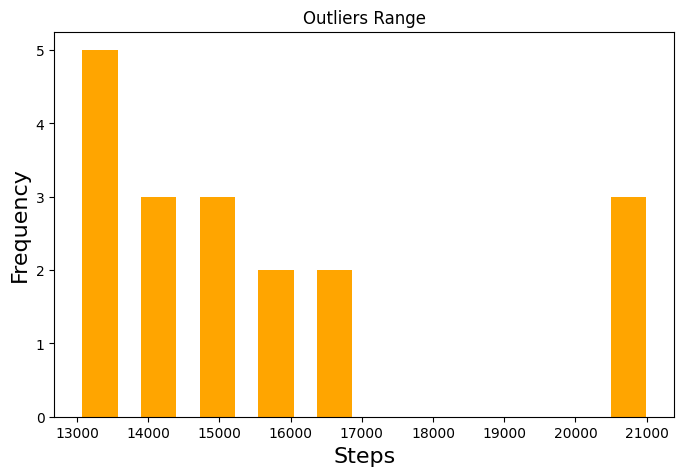

In [57]:
# 
plt.figure(figsize=(8, 5))
plt.hist(anomalies['steps'], bins= 10, rwidth=0.6, color='orange')
plt.xlabel('Steps')
plt.ylabel('Frequency')
plt.title('Outliers Range')
plt.show()

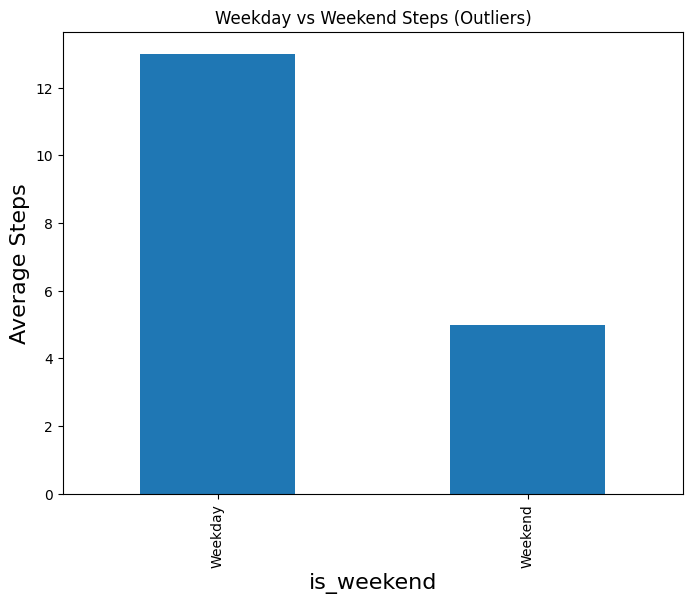

In [58]:
# Outliers VS week days
plt.figure(figsize=(8, 6))
anomalies.groupby('is_weekend')['steps'].count().plot(kind='bar', width = 0.5)
plt.xticks([0,1], ['Weekday', 'Weekend'])
plt.ylabel('Average Steps')
plt.title('Weekday vs Weekend Steps (Outliers)')
plt.show()

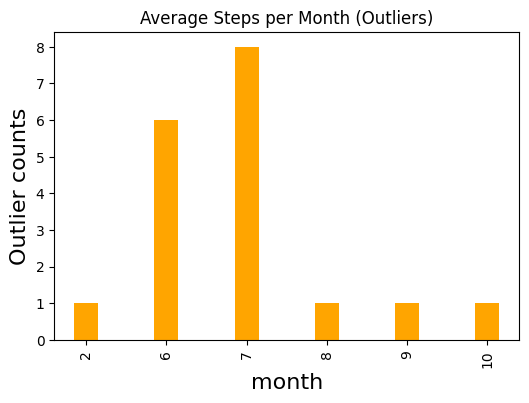

In [59]:
# Outliers VS Months

plt.figure(figsize=(6, 4))
anomalies.groupby('month')['steps'].count().plot(kind='bar', color='orange', width = 0.3)
plt.ylabel('Outlier counts')
plt.title('Average Steps per Month (Outliers)')
plt.show()

#### Report
weekday, hours, month

Weekday mean: 6270, Weekend mean: 4968


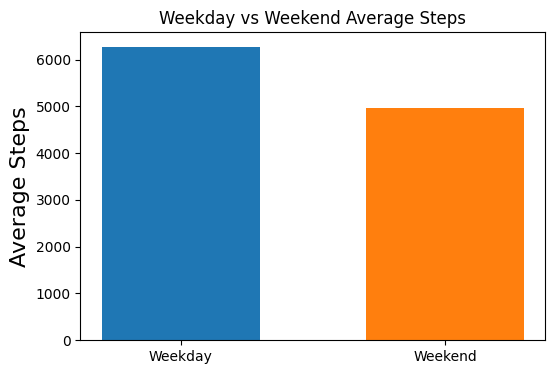

In [60]:
## Weekday VS Weekends
weekday_mean = df_filtered[df_filtered['is_weekend'] == False]['steps'].mean()
weekend_mean = df_filtered[df_filtered['is_weekend'] == True]['steps'].mean()

print(f"Weekday mean: {weekday_mean:.0f}, Weekend mean: {weekend_mean:.0f}")
means = [weekday_mean, weekend_mean]

plt.figure(figsize=(6,4))
plt.bar(['Weekday', 'Weekend'], means, color=['tab:blue', 'tab:orange'], width=0.6)
plt.ylabel('Average Steps')
plt.title('Weekday vs Weekend Average Steps')
plt.show()

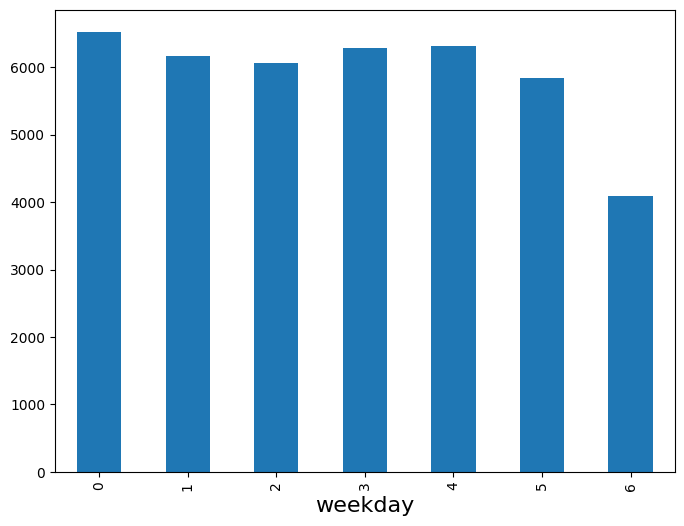

In [61]:
# Each day of a week
plt.figure(figsize=(8,6))
df_filtered.groupby(by='weekday')['steps'].mean().plot(kind='bar', width = 0.5)
plt.show()

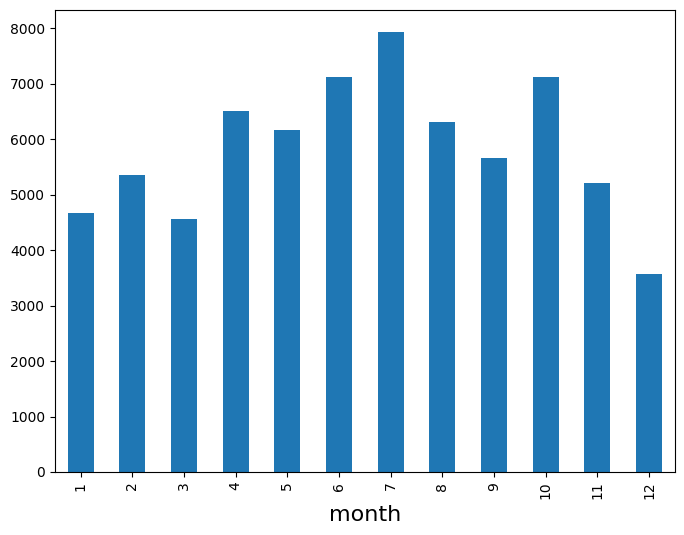

In [62]:
# Month
plt.figure(figsize=(8,6))
df_filtered.groupby(by='month')['steps'].mean().plot(kind='bar', width = 0.5)
plt.show()

In [69]:
# Function to map time to four periods of a day
def map_time_period(hour):
    if 6 <= hour <= 11:
        return 'morning'
    elif 12 <= hour <= 14:
        return 'noon'
    elif 15 <= hour <= 17:
        return 'afternoon'
    elif 18 <= hour <= 20:
        return 'evening'
    else:
        return 'night'


,steps,startDate,endDate,year,month,date,hour,time_period
30893,9.0,2024-01-01 02:24:55,2024-01-01 02:24:57,2024,1,2024-01-01,2,night
30894,1244.0,2024-01-01 09:57:09,2024-01-01 10:07:10,2024,1,2024-01-01,9,morning
30895,1298.0,2024-01-01 10:07:10,2024-01-01 10:17:11,2024,1,2024-01-01,10,morning
30896,1211.0,2024-01-01 10:17:11,2024-01-01 10:27:12,2024,1,2024-01-01,10,morning
30897,1222.0,2024-01-01 10:27:12,2024-01-01 10:37:13,2024,1,2024-01-01,10,morning


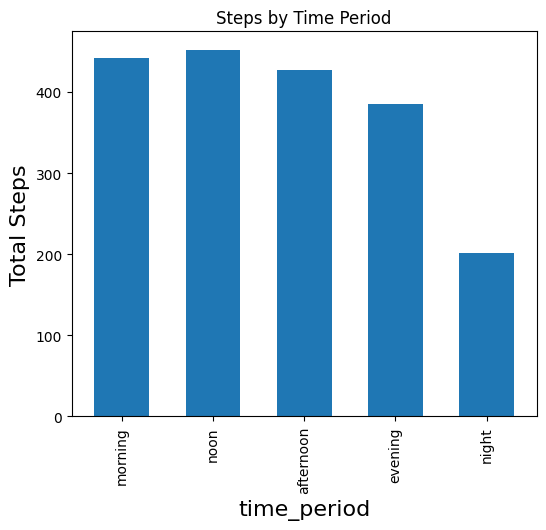

In [70]:
# *****************************************
df_filtered_by_hours = df_col_dropped[(df_col_dropped['year'] >= 2024) & (df_col_dropped['year'] <= 2025)]
df_filtered_by_hours['hour'] = df_filtered_by_hours['startDate'].dt.hour
df_filtered_by_hours['time_period'] = df_filtered_by_hours['hour'].apply(map_time_period)

# df_filtered['hour'] = df_filtered['startDate'].dt.hour
# df_filtered['time_period'] = df_filtered['hour'].apply(map_time_period)

display(df_filtered_by_hours.head())
time_period_mean = df_filtered_by_hours.groupby('time_period')['steps'].mean()

time_period_steps = time_period_mean.reindex(['morning','noon','afternoon','evening','night'])

plt.figure(figsize=(6,5))
time_period_steps.plot(kind='bar', color='tab:blue', width=0.6)
plt.ylabel('Total Steps')
plt.title('Steps by Time Period')
plt.show()

<Figure size 1000x500 with 0 Axes>

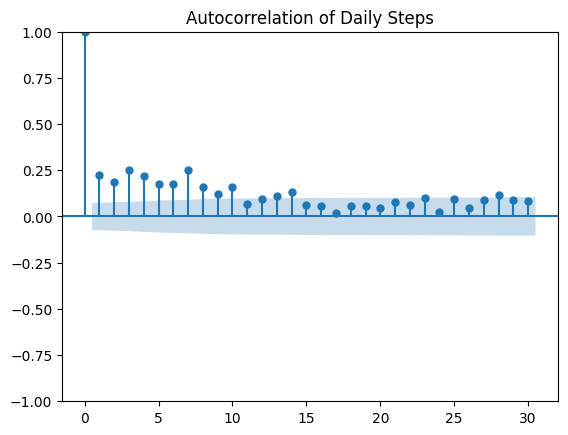

<Figure size 1000x500 with 0 Axes>

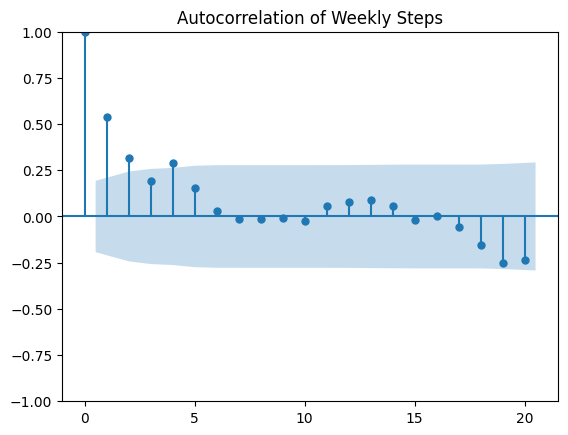

<Figure size 1000x500 with 0 Axes>

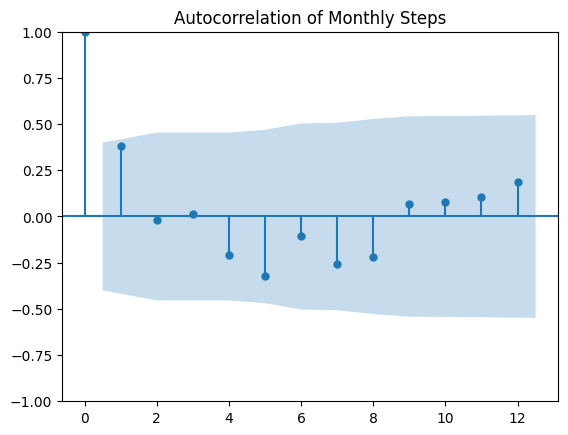

<Figure size 1000x300 with 0 Axes>

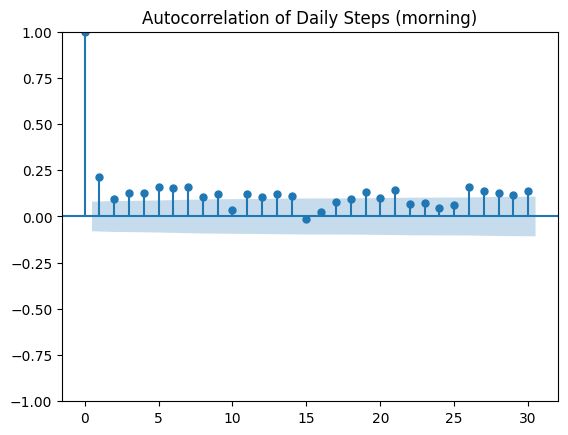

<Figure size 1000x300 with 0 Axes>

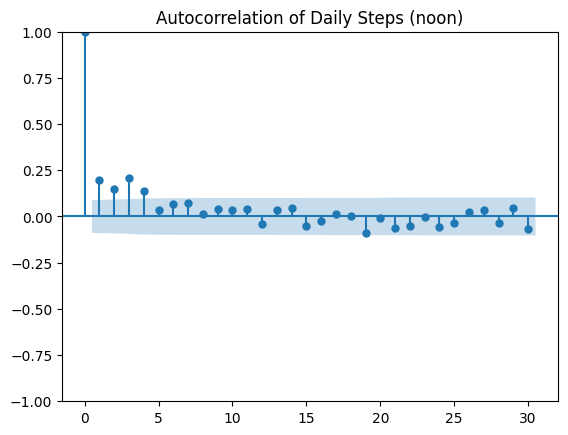

<Figure size 1000x300 with 0 Axes>

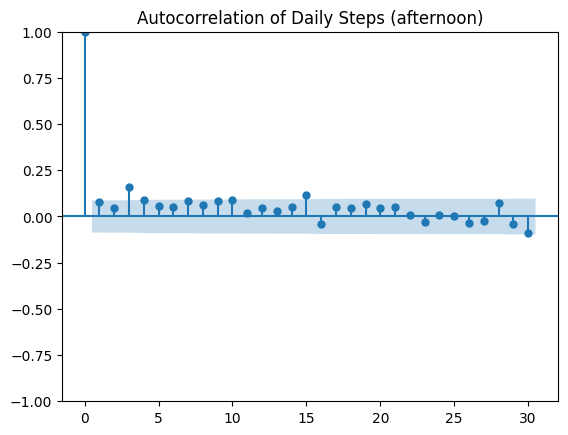

<Figure size 1000x300 with 0 Axes>

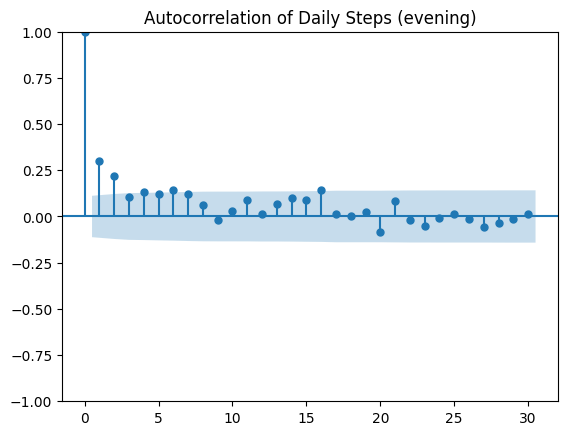

<Figure size 1000x300 with 0 Axes>

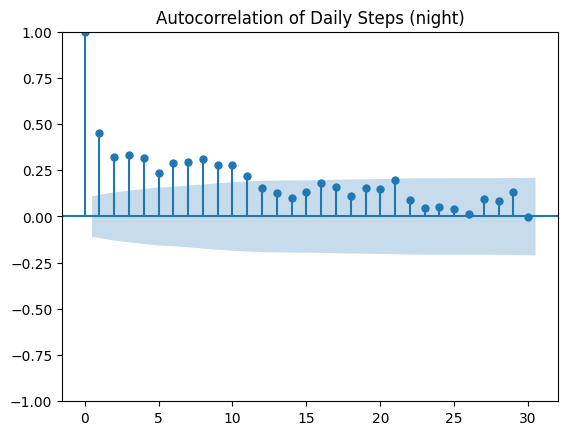

In [71]:

# ---------- 1. 每日步数自相关 ----------
plt.figure(figsize=(10,5))
plot_acf(df_filtered['steps'], lags=30)
plt.title('Autocorrelation of Daily Steps')
plt.show()

# ---------- 2. 每周总步数自相关 ----------
weekly_steps = df_filtered['steps'].resample('W').sum()
plt.figure(figsize=(10,5))
plot_acf(weekly_steps, lags=20)
plt.title('Autocorrelation of Weekly Steps')
plt.show()

# ---------- 3. 每月总步数自相关 ----------
monthly_steps = df_filtered['steps'].resample('M').sum()
plt.figure(figsize=(10,5))
plot_acf(monthly_steps, lags=12)
plt.title('Autocorrelation of Monthly Steps')
plt.show()

# ---------- 4. 各时间段每日步数自相关 ----------
time_periods = ['morning','noon','afternoon','evening','night']

for period in time_periods:
    period_steps = df_filtered_by_hours[df_filtered_by_hours['time_period'] == period]
    daily_period_steps = period_steps.groupby('date')['steps'].sum()
    
    if len(daily_period_steps) <= 1:
        print(f"Not enough data for {period}, skipping ACF")
        continue
    
    # lags 最大不能超过序列长度-1
    lags_to_use = min(30, len(daily_period_steps)-1)
    
    plt.figure(figsize=(10,3))
    plot_acf(daily_period_steps, lags=lags_to_use)
    plt.title(f'Autocorrelation of Daily Steps ({period})')
    plt.show()


In [72]:
def comput_cross_correlations(df, var_to_predict, vars_to_use, lags):
    X = []
    y = []

    for i in range(max(lags), len(df)):
        row = []
        skip = False
        for lag in lags:
            for var in vars_to_use:
                val = df[var].iloc[i-lag]
                if np.isnan(val):
                    skip = True
                row.append(val)
                
        # if original value has Nan, skip
        val_y = df[var_to_predict].iloc[i]
        if np.isnan(val_y):
            skip = True
            
        if skip:
            continue
        X.append(row)
        y.append(df[var_to_predict].iloc[i])

    # AR
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    
    # RMSE
    rmse = math.sqrt(mean_squared_error(y, y_pred))/(np.max(y)-np.min(y))
    return y, y_pred, rmse


,date,steps,startDate,endDate,year,month,weekday,is_weekend,z_score,afternoon,evening,morning,night,noon
0,2024-01-01,7464.0,2024-01-01 02:24:55,2024-01-01 13:38:58,2024,1,0,False,0.461400,0.0,0.0,7451.0,9.0,4.0
1,2024-01-02,7969.0,2024-01-02 08:45:20,2024-01-02 21:05:45,2024,1,1,False,0.610525,0.0,55.0,7209.0,40.0,665.0
2,2024-01-03,8866.0,2024-01-03 09:07:52,2024-01-03 18:42:13,2024,1,2,False,0.875406,969.0,1085.0,6812.0,0.0,0.0
3,2024-01-04,2108.0,2024-01-04 10:53:12,2024-01-04 21:51:27,2024,1,3,False,-1.120208,54.0,76.0,1920.0,21.0,37.0
4,2024-01-05,9112.0,2024-01-05 08:44:26,2024-01-05 22:08:26,2024,1,4,False,0.948049,2115.0,0.0,6988.0,9.0,0.0


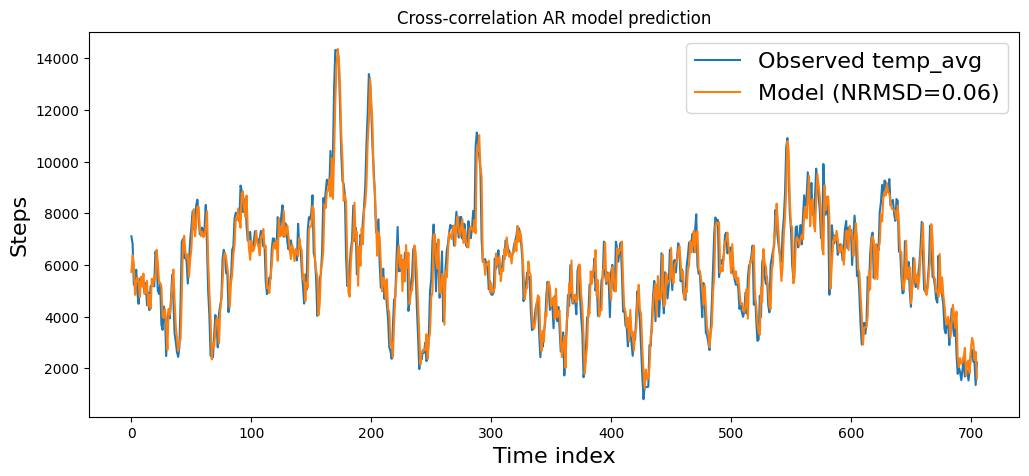

In [80]:
# Merge df_filtered_by_hours and df_filtered
time_features = (
    df_filtered_by_hours
    .groupby(['date', 'time_period'])['steps']
    .sum()
    .unstack(fill_value=0)
    .reset_index()
)

time_features['date'] = pd.to_datetime(time_features['date'])
df_daily = df_filtered.reset_index()
df_model = pd.merge(
    df_daily,
    time_features,
    on='date',
    how='inner'
)

display(df_model.head())
smoothed_steps = moving_average(df_model, 5)
var_to_predict = 'steps'
vars_to_use = ['month', 'weekday', 'afternoon', 'evening', 'morning', 'night', 'noon']
lags = [1, 2, 3, 4]
y_true, y_pred, nrmsd = comput_cross_correlations(smoothed_steps, var_to_predict, vars_to_use, lags)

plt.figure(figsize=(12,5))
plt.plot(y_true, label='Observed temp_avg', )
plt.plot(y_pred, label=('Model (NRMSD=%.2f)' % nrmsd if nrmsd > 0 else 'Model'))
plt.xlabel('Time index')
plt.ylabel('Steps')
plt.title('Cross-correlation AR model prediction')
plt.legend()
plt.show()

In [68]:
display(time_features.head(5))
display(df_filtered.head(5))

time_period,date,Afternoon,Evening,Morning,Night,Noon
0,2024-01-01,0.0,0.0,7451.0,9.0,4.0
1,2024-01-02,0.0,55.0,7209.0,40.0,665.0
2,2024-01-03,969.0,1085.0,6812.0,0.0,0.0
3,2024-01-04,54.0,76.0,1920.0,21.0,37.0
4,2024-01-05,2115.0,0.0,6988.0,9.0,0.0


,steps,startDate,endDate,year,month,weekday,is_weekend,z_score
date,,,,,,,,
2024-01-01,7464.0,2024-01-01 02:24:55,2024-01-01 13:38:58,2024,1,0,False,0.461400
2024-01-02,7969.0,2024-01-02 08:45:20,2024-01-02 21:05:45,2024,1,1,False,0.610525
2024-01-03,8866.0,2024-01-03 09:07:52,2024-01-03 18:42:13,2024,1,2,False,0.875406
2024-01-04,2108.0,2024-01-04 10:53:12,2024-01-04 21:51:27,2024,1,3,False,-1.120208
2024-01-05,9112.0,2024-01-05 08:44:26,2024-01-05 22:08:26,2024,1,4,False,0.948049
